In [3]:
import pandas as pd
from bs4 import BeautifulSoup
from contextlib import contextmanager 
from io import BytesIO 
from tempfile import NamedTemporaryFile 
from transformers import PretrainedConfig, PreTrainedModel 
from transformers import set_seed
from transformers import AdamW, BertForSequenceClassification, BertTokenizer, AutoTokenizer
from transformers import TextClassificationPipeline
from tqdm import tqdm
import json
import torch
import boto3
from psycopg2.extras import RealDictCursor
import psycopg2
import boto3
from psycopg2 import sql
from datetime import datetime
import json
import utils
import pandas as pd
import pathlib
import csv
import requests
import matplotlib as plt

In [15]:
city = "chi"
url = 'https://api.openaq.org/v1/measurements?city=Seattle-Tacoma-Bellevue&parameter=pm25&limit=500&location=Seattle-Beacon%20Hill&format=csv'
df_d = pd.read_csv(url)
df_d['local'] = pd.to_datetime(df_d['local']).dt.date
df_d.sort_values(['local','value'], ascending=[False,False], inplace=True)
df_d.drop_duplicates(subset=['local'], inplace=True)

In [4]:
db_host = 'openparl.cia2zobysfwo.us-west-2.rds.amazonaws.com'
db_port = 5432
db_user = 'rds'
db_region = 'us-west-2'
db_name = 'openparl'

client = boto3.client('rds', db_region)

db_token = client.generate_db_auth_token(db_host, db_port, db_user, Region=db_region)

connection = psycopg2.connect(database=db_name, host=db_host, user=db_user, password=db_token)

cursor = connection.cursor(cursor_factory=RealDictCursor)

In [11]:
table_aq = "us_" + city + "_aq_meeting"
table_gen = "us_" + city + "_gen_meeting"

try:
    select_table = sql.SQL(""" 
        SELECT * FROM public.{table}
    """).format(table = sql.Identifier(table_aq))

    cursor.execute(select_table)
    result_aq = cursor.fetchall() 
except Exception as e:
    print(f"An exception occured while fetchng table:\n{e}")
    cursor.connection.rollback()


try:
    select_table = sql.SQL(""" 
        SELECT * FROM public.{table}
    """).format(table = sql.Identifier(table_gen))

    cursor.execute(select_table)
    result_gen = cursor.fetchall() 
except Exception as e:
    print(f"An exception occured while fetchng table:\n{e}")
    cursor.connection.rollback()

70


<AxesSubplot:xlabel='local', ylabel='value'>

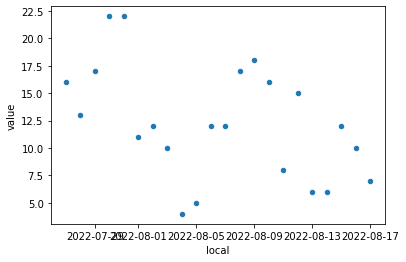

In [19]:
df_aq = pd.DataFrame(result_aq)
df_gen = pd.DataFrame(result_gen)

x_axis = ["AQ","Environment","Foreign Policy","Government","Infrastructure","Law","Welfare"]
y_axis = [len(df_aq)]
env = df_gen.apply(lambda x : True if x['topic'] == "environment" else False, axis = 1)
  
# Count number of True in the series
num_rows = len(df_gen[env == True].index)
print(num_rows)

df_d.plot(x ='local', y='value', kind = 'scatter')